<a href="https://colab.research.google.com/github/nsriniva/DS-Unit-1-Build/blob/master/DS_Unit_1_BuildProject_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
from collections import OrderedDict
from math import isclose
import zipfile 
from urllib.request import urlopen
import io

import requests
from bs4 import BeautifulSoup

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import chi2_contingency

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression

# Uploaded 
# https://archive.ics.uci.edu/ml/machine-learning-databases/00332/OnlineNewsPopularity.zip 
# to my github repo  from 
# https://archive.ics.uci.edu/ml/datasets/Online+News+Popularity

onp_url = 'https://github.com/nsriniva/DS-Unit-1-Build/blob/master/OnlineNewsPopularity.zip?raw=true'

# Open the zip file
zfile = urlopen(onp_url)

# Create an IO stream
zfile_mem = io.BytesIO(zfile.read())

# Extract data file from archive and load into dataframe
# The zip archive contains the data file 
# OnlineNewsPopularity/OnlineNewsPopularity.csv 
# and the info file 
# OnlineNewsPopularity/OnlineNewsPopularity.names.
# Use the zipfile package to open the archive and read the data file
with zipfile.ZipFile(zfile_mem) as zf:
  with zf.open('OnlineNewsPopularity/OnlineNewsPopularity.csv') as f:
    onp_df = pd.read_csv(f)

In [15]:
null_values = onp_df.isna().sum().sum()

print(f"There are {['','no'][int(null_values==0)]} invalid values in the dataset!")

# Clean up the column names by removing the leading whitespace
column_names = (x.strip() for x in onp_df.columns)
onp_df.columns = list(column_names)

# Remove both non-predictive attributes
onp_predictive_df = onp_df.drop(columns=['url', 'timedelta'])

# Drop the target/goal attribute
onp_predictive_df = onp_predictive_df.drop(columns=['shares'])
#display(onp_predictive_df.head(), onp_predictive_df.shape)

onp_df.shape

# First, identify all the data_channel_is_*/weekday_is_* columns
data_channel_columns = list(filter(lambda x: x.startswith('data_channel_is_'), onp_df.columns))
weekday_columns = list(filter(lambda x: x.startswith('weekday_is_'), onp_df.columns))

display(onp_df.shape, data_channel_columns, weekday_columns)

There are no invalid values in the dataset!


(39644, 61)

['data_channel_is_lifestyle',
 'data_channel_is_entertainment',
 'data_channel_is_bus',
 'data_channel_is_socmed',
 'data_channel_is_tech',
 'data_channel_is_world']

['weekday_is_monday',
 'weekday_is_tuesday',
 'weekday_is_wednesday',
 'weekday_is_thursday',
 'weekday_is_friday',
 'weekday_is_saturday',
 'weekday_is_sunday']

In [16]:
# Combine all data_channel_is_*/weekday_is_* columns into one single categorical 
# column 'data_channel'/'weekday'



# Compute a mapping between the data channel/weekday name and an integer
# value i.e. 'misc':0,'lifestyle':1/'monday':1, ... 
dcm = OrderedDict()
wm = OrderedDict()
prel = len('data_channel_is_')
dcm['misc'] = 0
for idx,name in enumerate(data_channel_columns):
  dcm[name[prel:]] = idx+1
prel = len('weekday_is_')
for idx,name in enumerate(weekday_columns):
  wm[name[prel:]] = idx+1

# mf(u, args) => args if u is True and 0 otherwise.
mf = lambda u,args: [0,args][int(u)]

# This function adds a new column named new_col with the information
# from all the columns prefixed with new_col+'_is_' and then returns a
# dataframe with all them dropped.
def mapper_func(df, new_col, name_dict, ignore=0):
  name_list = list(name_dict.items())

  i = 0
  while name_list[i][1]==ignore:
    i += 1
  
  first = name_list[i]

  df[new_col] = df[new_col+'_is_'+first[0]].apply(mf, args=(name_dict[first[0]],))
  for name,_ in name_list[i+1:]:
    df[new_col] = df[new_col] + df[new_col+'_is_'+name].apply(mf, args=(name_dict[name],))
  return df.drop(columns=[ new_col+'_is_'+name for name,_ in name_list[i:]])

# Combining all data_channel_is_* columns into one single categorical column
# data_channel - drop all the original data_channel_is_* columns
onp_merged_df = mapper_func(onp_predictive_df, 'data_channel', dcm)

# Combing all weekday_is_* columns into one single categorical column
# weekday - drop all the original weekday_is_* columns
onp_merged_df = mapper_func(onp_merged_df, 'weekday', wm)


display(onp_merged_df.data_channel.value_counts())
display(dcm)
display(onp_merged_df.weekday.value_counts())

#dcm_key_names = ['misc', 'lifestyle', 'entertainment','bus', 'socmed', 'tech',
#                 'world', 'culture', 'u.s.', 'social-good']]
dcm['culture'] = 7
dcm['u.s.'] = 8
dcm['social-good'] = 9

data_channel_fixed_url = 'https://raw.githubusercontent.com/nsriniva/DS-Unit-1-Build/master/data_channel_cleaned_df.csv'

data_channel_cleaned_df = pd.read_csv(data_channel_fixed_url)

for idx in data_channel_cleaned_df.index:
  row = data_channel_cleaned_df.iloc[idx]
  onp_merged_df.data_channel.iloc[row['idx']] = row['data_channel']



# Drop the is_weekend column because it contains redundant information.
onp_merged_df = onp_merged_df.drop(columns=['is_weekend'])

display(onp_merged_df.data_channel.value_counts())
display(dcm)

#display(onp_merged_df.head(), onp_merged_df.shape, onp_merged_df.data_channel.value_counts(), onp_merged_df.weekday.value_counts())

6    8427
5    7346
2    7057
3    6258
0    6134
4    2323
1    2099
Name: data_channel, dtype: int64

OrderedDict([('misc', 0),
             ('lifestyle', 1),
             ('entertainment', 2),
             ('bus', 3),
             ('socmed', 4),
             ('tech', 5),
             ('world', 6)])

3    7435
2    7390
4    7267
1    6661
5    5701
7    2737
6    2453
Name: weekday, dtype: int64

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


6    9513
2    8384
5    8219
3    6980
4    2323
1    2099
7    1917
8     138
9      46
0      25
Name: data_channel, dtype: int64

OrderedDict([('misc', 0),
             ('lifestyle', 1),
             ('entertainment', 2),
             ('bus', 3),
             ('socmed', 4),
             ('tech', 5),
             ('world', 6),
             ('culture', 7),
             ('u.s.', 8),
             ('social-good', 9)])

In [17]:
#Let's try some linear regression
def linear_regression(df, outliers= None):
  if outliers is None:
    X = df.values 
    Y = onp_df.shares.values.reshape(-1,1)
  else:
    X = df.drop(outliers).reindex().values
    Y = onp_df.drop(outliers).reindex().shares.values.reshape(-1,1)

  lr = LinearRegression()
  lr.fit(X,Y)
  Yc = lr.predict(X)

  error = Y-Yc

  num = len(Y)

  # Mean absolute error
  mae = np.abs(error).sum()/num
  # Mean square error
  mse = np.linalg.norm(error)/num**0.5
  
  return num, mae, mse, len(X), Y, Yc



In [18]:
def get_outliers_filter(sigma=3):
  z = np.abs(stats.zscore(onp_df.shares))
  return np.where(z>sigma)[0]

def linear_regressions(outliers=None):
  errors = {}

  if outliers is not None:
    outliers = get_outliers_filter(outliers)

  errors['predictive'] = linear_regression(onp_predictive_df, outliers)
  errors['merged'] = linear_regression(onp_merged_df, outliers)

  return errors
 

In [19]:
def remove_outliers(df, sigma=3):
  return df.drop(get_outliers_filter(sigma)).reindex()

def get_outliers(df, sigma=3):
  rem_df = df.drop(get_outliers_filter(sigma)).assign(shares=onp_df.drop(get_outliers_filter(sigma)).shares)
  out_df =  df.loc[get_outliers_filter(sigma)].assign(shares=onp_df.loc[get_outliers_filter(sigma)].shares)
  return out_df, rem_df

def partition_on_shares(df, sigma=1):

  out_df, rem_df = get_outliers(onp_merged_df, sigma)

#  display(out_df.shape, out_df.shares.min(), out_df.shares.max(), out_df.shares.mean(),out_df.shares.median())
#  print('\n')
#  display(rem_df.shape, rem_df.shares.min(), rem_df.shares.max(), rem_df.shares.mean(),rem_df.shares.median())
#  print('\n')
  rem_df['popular'] = rem_df.shares >= rem_df.shares.median()
  out_df['popular'] = out_df.shares >= out_df.shares.median()
  rem_df.popular = rem_df.popular.apply(int)
  out_df.popular = out_df.popular.apply(int)

#  display(rem_df.shape, rem_df.popular.value_counts())
#  print('\n')
#  display(out_df.shape, out_df.popular.value_counts())
  return rem_df, out_df

def display_partition(df, vdf=None):
  prnt_norm = lambda  df_,min, max: print(f'num entries:{df_.shape[0]:6d} min:{min:5d} max:{max:6d} median:{df_.shares.median()} ')
  prnt_tuple = lambda  df_,min, max: print(f'num entries:{df_.shape[0]:6d} min:{min} max:{max} median:{df_.shares.median()} ')

  dmin = df.shares.min()

  for tdf in (df, vdf):

    if tdf is None:
      continue
      
    min = tdf.shares.min()
    max = tdf.shares.max()

    if min < dmin:
      svdf = tdf.shares.sort_values()
      i = 0
      e = svdf.iloc[i]
      while e < dmin:
        i += 1
        e = svdf.iloc[i]
      min = (min, svdf.iloc[i-1])
      max = (e, max)
      prnt_tuple(tdf, min, max)
    else:  
      prnt_norm(tdf, min, max)


In [20]:
def display_sigmas(sigmas, err):
  for i,sigma in enumerate(sigmas):
    if sigma is not None:
      print(f'Sigma = {sigma}')
      pop_df, vpop_df = partition_on_shares(onp_merged_df, sigma)
      display_partition(pop_df, vpop_df)
    else:
      display_partition(onp_merged_df.assign(shares=onp_df.shares))

    display(err[i])
    print('\n')

err =[]
sigmas=[None, 3,2,1, 0.5, 0.375, 0.25, 0.125]
for i in sigmas:
  err.append(linear_regressions(i))


#display_sigmas(sigmas, err)

In [21]:
def display_error_graph(err, ax0, ax1, ax2, title='Title'):
  p = err['predictive']
  m = err['merged']

  X = list(range(p[3]))
  Y = p[4]
  Ycp = p[5]
  Ycm = m[5]

  tX = 40000

  ax0.set_title(title)
  ax0.plot(X, Y, color='blue' )
  ax0.plot([-5000, 50000], [Y.min(), Y.min()])
  ax0.text(tX, Y.min()+100, f'MIN={Y.min()}')
  ax0.plot([-5000, 50000], [Y.max(), Y.max()])
  ax0.text(tX, Y.max()+100, f'MAX={Y.max()}')

  ax1.plot(X,Ycp, color='orange')
  ax2.plot(X,Ycm, color='brown')

  ax1.plot([-5000,50000],[p[1],p[1]], color='magenta')
  ax1.text(tX, p[1]+100, f'MAE={p[1]:1.0f}')
  ax2.plot([-5000,50000],[m[1],m[1]], color='magenta')
  ax2.text(tX, m[1]+100, f'MAE={m[1]:1.0f}')

  
def display_corr(df, ax,sfx='Low'):
## heatmeap to see the correlation between features. 
# Generate a mask for the upper triangle (taken from seaborn example gallery)
  df_corr = df.corr()

  mask = np.zeros_like(df_corr, dtype=np.bool)
  mask[np.triu_indices_from(mask)] = True

  sns.heatmap(df_corr, 
              annot=False,
              mask = mask,
              cmap = 'RdBu_r',
              linewidths=0.1, 
              linecolor='white',
              vmax = .9,
              ax = ax,
              square=True)
  
  ax.text(1, 1,f'min({df.shares.min()}) max({df.shares.max()}) num({len(df.shares)})', fontsize='x-large')
  ax.set_title(f'Correlations Among Features in the {sfx} Popularity Range', y = 1.03,fontsize = 20);



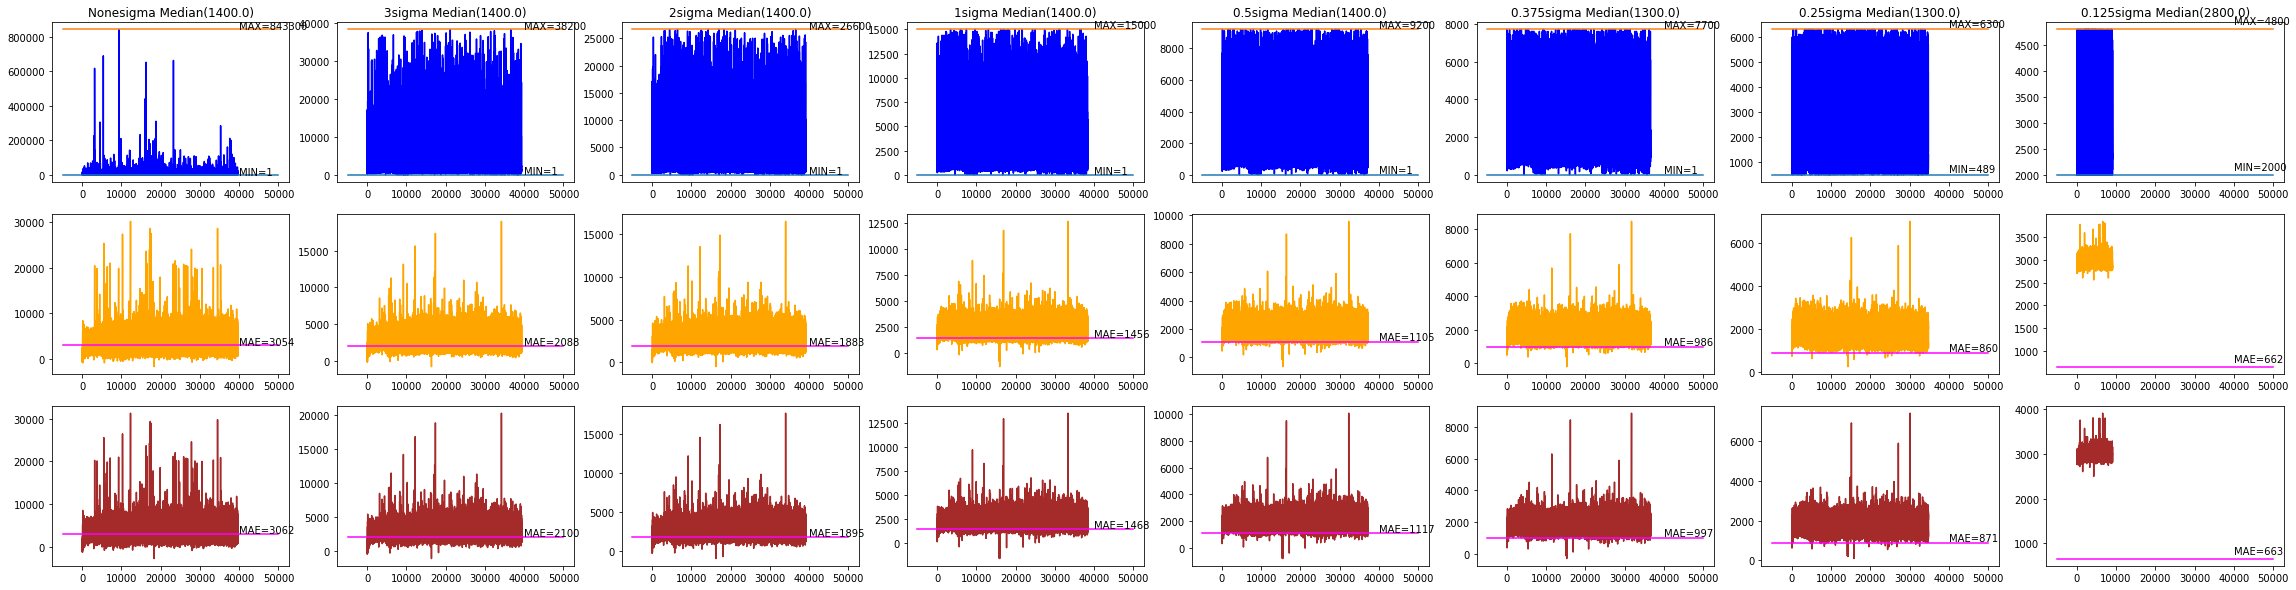

In [22]:
fig,ax = plt.subplots(3,len(sigmas), figsize=(40,10))

for i,sigma in enumerate(sigmas):
  display_error_graph(err[i], ax[0][i], ax[1][i], ax[2][i], title=f'{sigma}sigma Median({pd.Series(err[i]["merged"][4].reshape(-1)).median()})')

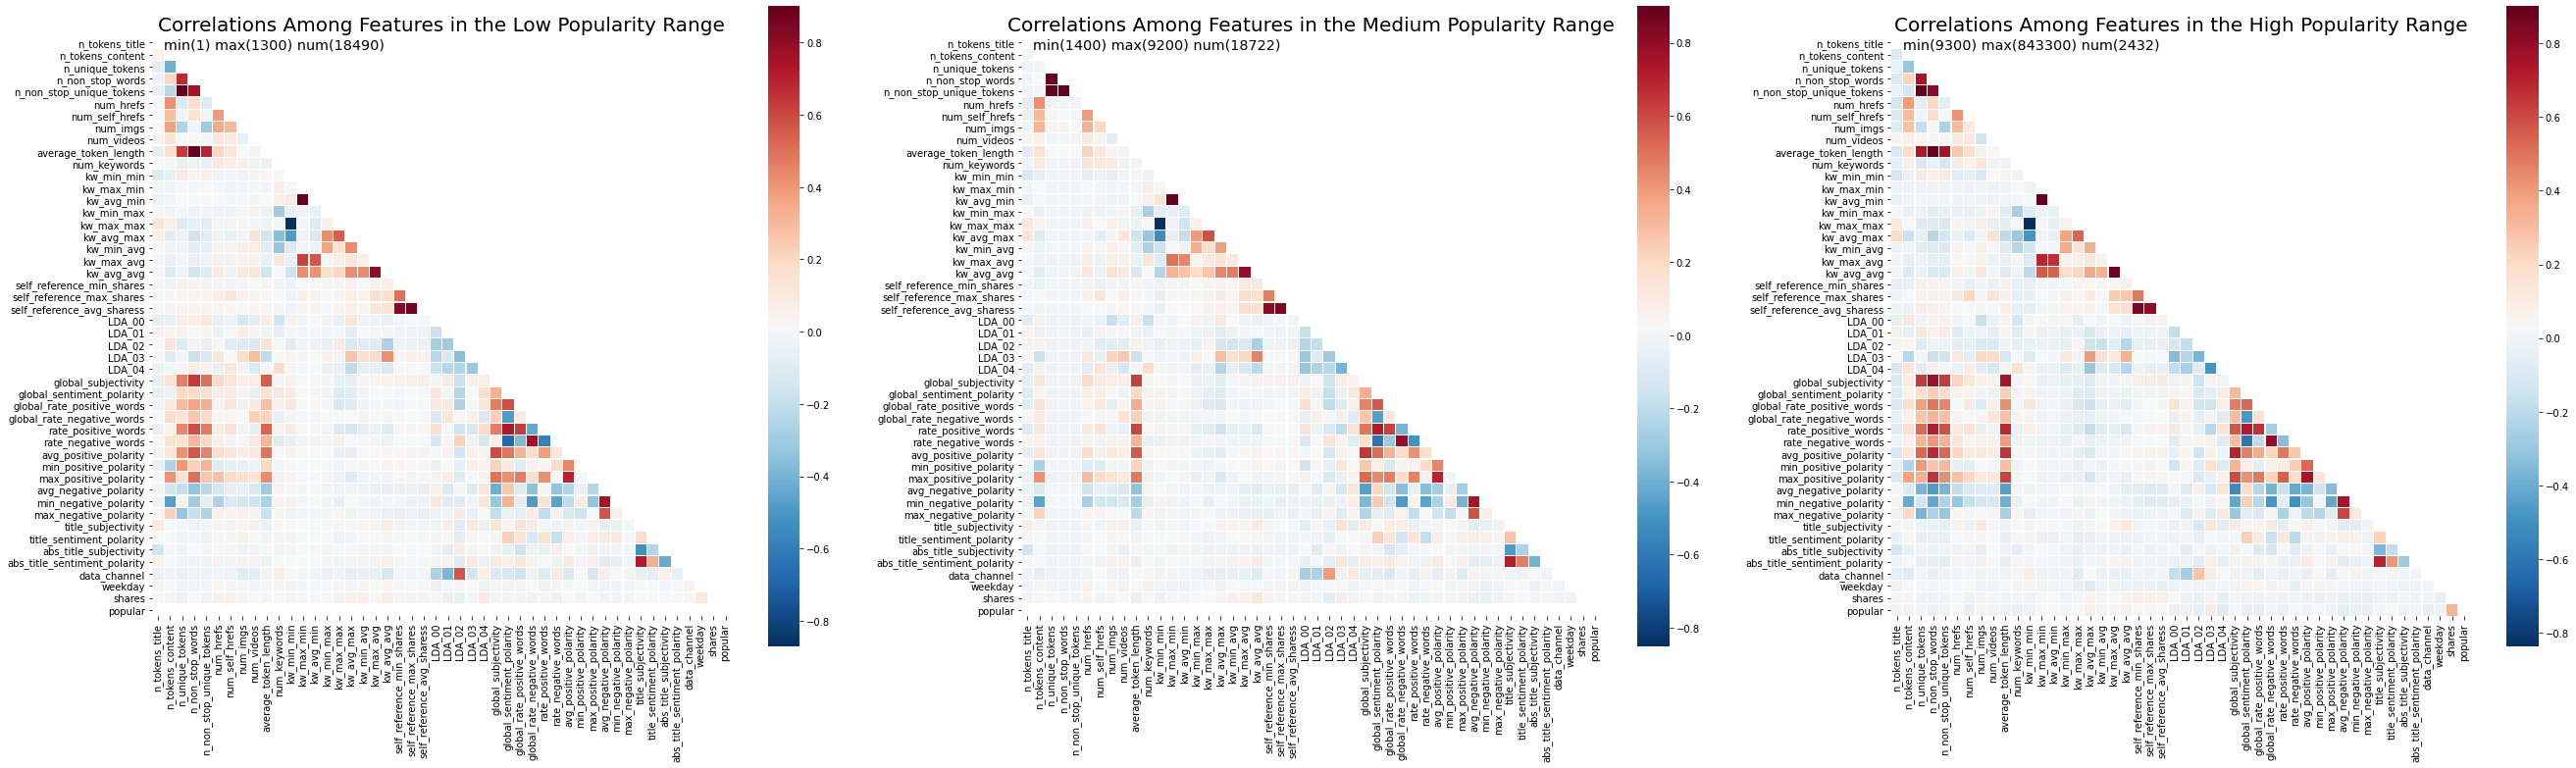

In [23]:
pop_df, hpop_df = partition_on_shares(onp_merged_df, 0.5)

pop_df_grouped = pop_df.groupby(pop_df.popular)

lpop_df = pop_df_grouped.get_group(0)
mpop_df = pop_df_grouped.get_group(1)

fig, ax = plt.subplots(1,3,figsize = (45,12))

display_corr(lpop_df,ax[0])
display_corr(mpop_df,ax[1], 'Medium')
display_corr(hpop_df,ax[2], 'High')

In [24]:
def plot_against_popular_level(df,ax, col='data_channel', title='Low', name_dict=dcm, two=True, display_both=False, color='green', left=False):

  #display(pd.crosstab(df[col], df.popular))
  chi2 = chi2_contingency(pd.crosstab(df[col], df.popular))
  #print(f'{len(df.popular)} {len(df[col])} chi2<{chi2}>')
  #print(f'P values for <{col}> vs <popular> is {chi2[1]:.4f}\n')

  if chi2[1] > 0.01 and display_both:
    return

  #df.plot.scatter(x=col, y='shares')

  norm = 'columns'
  if two and display_both:
    norm = True
  col_shares_cond = pd.crosstab(df[col], df.popular, normalize=norm)

  pops = len(df.popular.unique())
  N = len(df[col].unique())
  #display(col_shares_cond, N)

  if two:
    not_pop = col_shares_cond.iloc[:,0]*100
    pop = col_shares_cond.iloc[:,1]*100
  else:
    pop = col_shares_cond.iloc[:,0]
    for p in range(1,pops):
#      pop = (col_shares_cond.iloc[:,0] + col_shares_cond.iloc[:,1])*50
      pop = pop + col_shares_cond.iloc[:,p]
    pop = (pop*100)/pops

  #This is more graphical stuff
  ind = np.arange(N)  # the x locations for the groups
  width = 0.4       # the width of the bars

  

  if two and display_both:
    rects1 = ax.bar(ind, not_pop, width, color='brown') #bars for not popular
  rects2 = ax.bar(ind + width, pop, width, color=color) #bars for popular

  div = [1,2][int(two and display_both)]

  Tx = 0
  if not left:
    Tx = ax.get_xlim()[1]*0.75
# add some text for labels, title and axes ticks
  ax.set_ylabel('Percent')
  ax.text(Tx, ax.get_ylim()[1]-1,f'min({df.shares.min()})', fontsize='large')
  ax.text(Tx, ax.get_ylim()[1]-2,f'max({df.shares.max()})', fontsize='large')
  ax.text(Tx, ax.get_ylim()[1]-3,f'num({len(df.shares)})', fontsize='large')
  ax.set_title(f'Percent of  articles that are {title} Popularity by {col} type')
  ax.set_xticks(ind + width / div)
  ax.set_xticklabels(name_dict.keys(), rotation='vertical')

  for p in ax.patches:
    w = p.get_width()
    h = p.get_height()
    x,y = p.get_xy()
    ax.annotate(f'{h/100:.1%}',(x+w/2,y+h*1.01), ha='center')

  if two and display_both:
    ax.legend((rects1[0], rects2[0]), (f'{title[0]}Popular', f'{title[1]}Popular'));



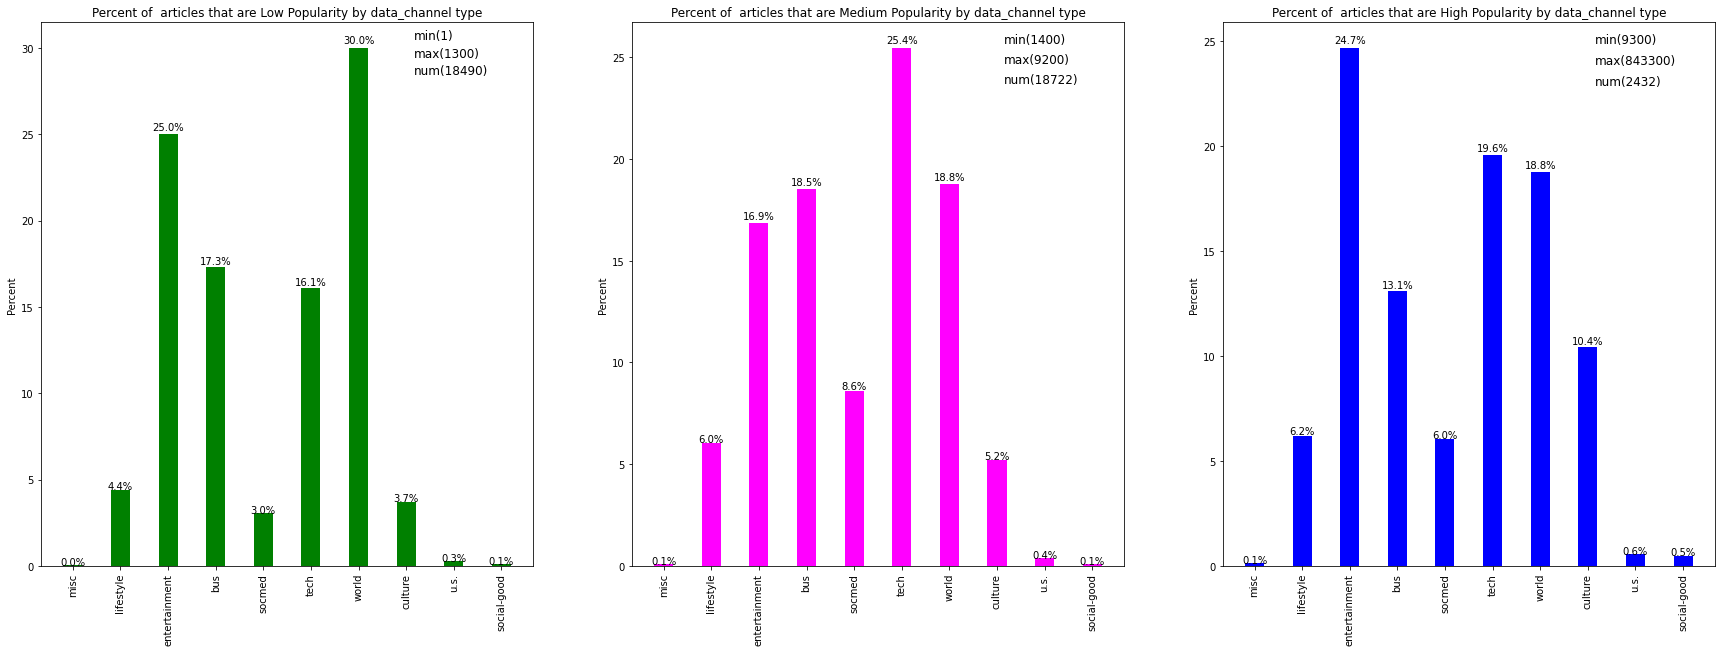

In [25]:
#Create the plot
fig, ax = plt.subplots(1,3,figsize=(30,10))

plot_against_popular_level(lpop_df, ax[0],two=False)
plot_against_popular_level(mpop_df, ax[1],title='Medium',two=False, color='magenta')
plot_against_popular_level(hpop_df, ax[2], title='High',two=False, color='blue')



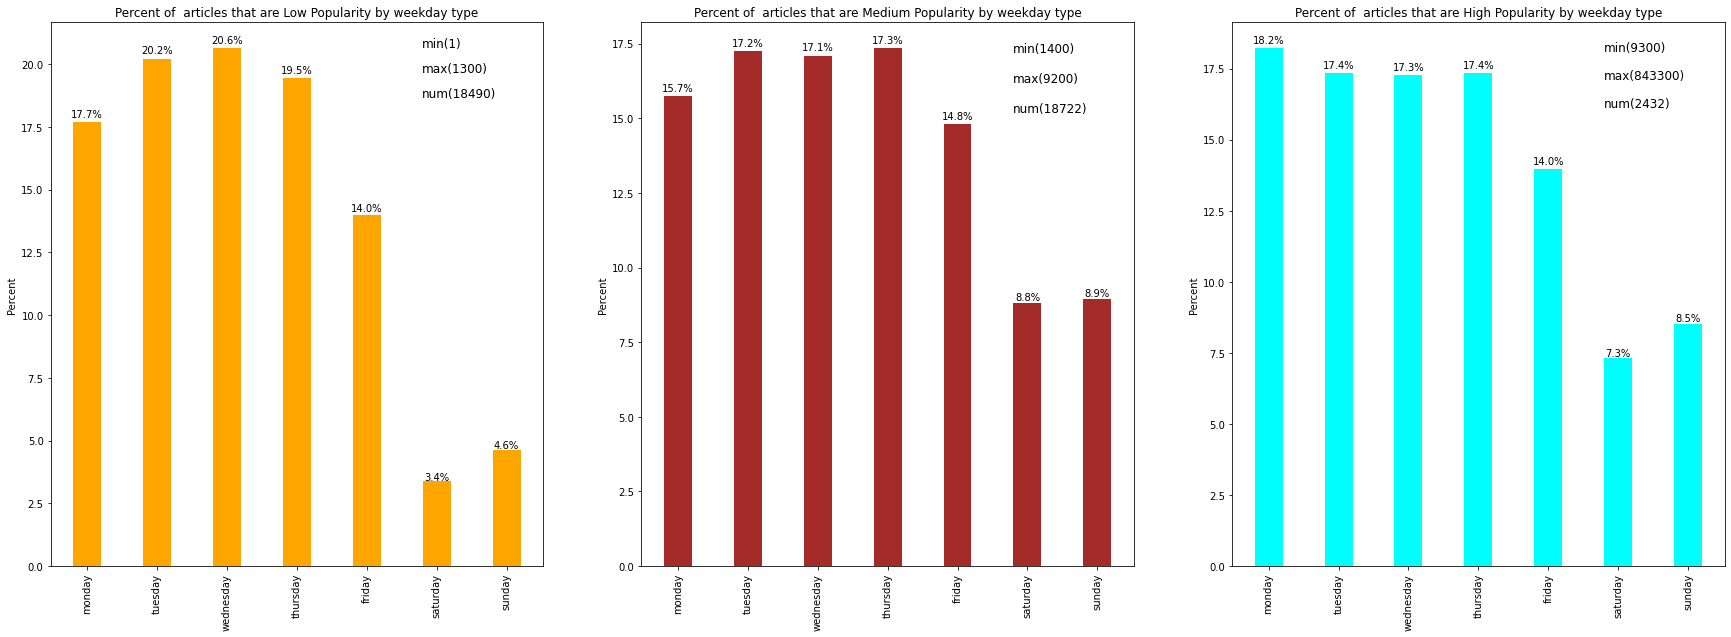

In [26]:
#Create the plot
fig, ax = plt.subplots(1,3,figsize=(30,10))

plot_against_popular_level(lpop_df,ax[0], col='weekday', name_dict=wm, two=False, color='orange')
plot_against_popular_level(mpop_df,ax[1], col='weekday', title='Medium',name_dict=wm, two=False, color='brown')
plot_against_popular_level(hpop_df,ax[2], col='weekday', title='High',name_dict=wm, two=False, color='cyan')
